In [13]:
import torch
print(torch.__version__)  # Should be 1.12+; as of 2025, latest is 2.3+ or higher
print(torch.backends.mps.is_available())  # Should return True on M1 Max
print(torch.backends.mps.is_built())  # Confirms MPS support is compiled in

2.7.1
True
True


In [14]:
# Step 1: Imports
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Device setup for GPU if available (MPS for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [23]:
# Step 2: Load Datasets
# Load training and testing data (tweets with pre-computed MI metrics)
train_df = pd.read_excel('/Users/myronkneip/nitter_scraper/Final/Training_data.xlsx', sheet_name='Sheet1')
test_df = pd.read_excel('/Users/myronkneip/nitter_scraper/Final/Testing_data.xlsx', sheet_name='Sheet1')

# Load OHLCV data for backtesting (align by timestamps)
ohlcv_df = pd.read_excel('/Users/myronkneip/nitter_scraper/Final/OHLC_data.xlsx', sheet_name='Sheet1')
# Assuming 'Dates' is a Unix timestamp; replace 'unit' with 'ms' if needed (see check below)
ohlcv_df['Dates'] = pd.to_datetime(ohlcv_df['Dates'], unit='s', errors='coerce')  # Convert to datetime for merging

# Merge OHLCV with train/test for baseline alignment (use nearest timestamp match)
train_df = train_df.merge(ohlcv_df, left_on='Timestamp', right_on='Dates', how='left')
test_df = test_df.merge(ohlcv_df, left_on='Timestamp', right_on='Dates', how='left')

# Define oil-related keywords for topic detection
oil_keywords = ['oil', 'crude', 'WTI', 'brent', 'opec', 'shale', 'drill', 'rig', 'barrel', 'refinery', 'pipeline', 'tariff', 'sanction', 'iran', 'saudi', 'russia', 'explosion', 'missile', 'geopolitical', 'supply', 'demand', 'inventory', 'export', 'import']

# Function to detect if tweet is oil-related (with handling for non-string values)
def is_oil_related(tweet):
    if isinstance(tweet, str):
        tweet_lower = tweet.lower()
        return any(word in tweet_lower for word in oil_keywords)
    else:
        return False  # Non-strings (e.g., NaN) are not oil-related

# Filter datasets for oil-related tweets only
train_df = train_df[train_df['Tweet'].apply(is_oil_related)]
test_df = test_df[test_df['Tweet'].apply(is_oil_related)]

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'device' is defined earlier as torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Step 3: Feature Engineering - Entropy for Narrative Shifts and BERT Embeddings
# Sort by timestamp for sequential processing
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

# Compute entropy over rolling windows (e.g., last 10 tweets) for narrative conviction
def compute_entropy(tweets_window):
    tweets_window = [str(t) for t in tweets_window]  # Ensure all are strings
    if len(tweets_window) < 2:
        return 0.0  # Low entropy if insufficient data
    word_counts = pd.Series(' '.join(tweets_window).split()).value_counts()
    probs = word_counts / word_counts.sum()
    return entropy(probs)

window_size = 10  # Adjust based on data density

# Manual rolling computation to handle string columns
def compute_rolling_entropy(df, col='Tweet', window_size=10):
    entropy_values = []
    for i in range(len(df)):
        start = max(0, i - window_size + 1)
        window = df[col].iloc[start:i+1]
        entropy_values.append(compute_entropy(window))
    return entropy_values

train_df['Entropy'] = compute_rolling_entropy(train_df, window_size=window_size)
test_df['Entropy'] = compute_rolling_entropy(test_df, window_size=window_size)

# Handle NaNs in entropy
train_df['Entropy'] = train_df['Entropy'].fillna(0)
test_df['Entropy'] = test_df['Entropy'].fillna(0)

# Threshold for narrative shift: High entropy = noise (filter out), low = conviction (keep for signals)
entropy_threshold = train_df['Entropy'].quantile(0.75)  # Top 25% entropy as "noise"

# BERT for tweet embeddings (NLP features)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(tweet):
    if not isinstance(tweet, str):  # Handle non-string (e.g., NaN) safely
        return np.zeros(768)  # Return zero vector for invalid tweets; adjust dim if using different BERT
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

train_df['BERT_Embedding'] = train_df['Tweet'].apply(get_bert_embedding)
test_df['BERT_Embedding'] = test_df['Tweet'].apply(get_bert_embedding)

# Stack embeddings into arrays for ML
train_embeddings = np.stack(train_df['BERT_Embedding'].values)
test_embeddings = np.stack(test_df['BERT_Embedding'].values)

# Add entropy as feature
train_features = np.hstack([train_embeddings, np.array(train_df['Entropy']).reshape(-1, 1)])
test_features = np.hstack([test_embeddings, np.array(test_df['Entropy']).reshape(-1, 1)])

# Targets: Use MI columns as multi-output regression targets (e.g., 1min, 5min, etc.)
mi_columns = [col for col in train_df.columns if col.startswith('MI_')]  # All MI metrics
train_targets = train_df[mi_columns].values

# Handle NaNs and infs in targets
train_targets = np.nan_to_num(train_targets, nan=0.0, posinf=0.0, neginf=0.0)

# Check if MI columns exist in test_df before extracting
if all(col in test_df.columns for col in mi_columns):
    test_targets = test_df[mi_columns].values
    test_targets = np.nan_to_num(test_targets, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infs
else:
    test_targets = None  # Or handle as needed (e.g., for prediction only)
    print("Warning: MI columns not found in test_df. Proceeding without test_targets.")

# Scale features and targets
feature_scaler = StandardScaler().fit(train_features)
target_scaler = StandardScaler().fit(train_targets)

train_features_scaled = feature_scaler.transform(train_features)
test_features_scaled = feature_scaler.transform(test_features)
train_targets_scaled = target_scaler.transform(train_targets)

# Handle any NaNs produced by scaling (e.g., due to constant columns with zero variance)
train_targets_scaled = np.nan_to_num(train_targets_scaled, nan=0.0, posinf=0.0, neginf=0.0)

if test_targets is not None:
    test_targets_scaled = target_scaler.transform(test_targets)
    test_targets_scaled = np.nan_to_num(test_targets_scaled, nan=0.0, posinf=0.0, neginf=0.0)
else:
    test_targets_scaled = None

# Identify and print constant MI columns (zero variance)
zero_var_indices = np.where(target_scaler.var_ == 0)[0]
if len(zero_var_indices) > 0:
    zero_var_columns = [mi_columns[i] for i in zero_var_indices]
    print("Warning: The following MI columns have zero variance (constant values) and may cause issues:", zero_var_columns)
else:
    print("No zero-variance MI columns detected.")

# NaN checks
print("NaNs in train_features_scaled:", np.isnan(train_features_scaled).any())
print("NaNs in train_targets_scaled:", np.isnan(train_targets_scaled).any())
if test_targets_scaled is not None:
    print("NaNs in test_features_scaled:", np.isnan(test_features_scaled).any())
    print("NaNs in test_targets_scaled:", np.isnan(test_targets_scaled).any())

# Validation split from training data
X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, train_targets_scaled, test_size=0.2, shuffle=False)  # No shuffle for time-series

No zero-variance MI columns detected.
NaNs in train_features_scaled: False
NaNs in train_targets_scaled: False
NaNs in test_features_scaled: False
NaNs in test_targets_scaled: False


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'device' is defined earlier as torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Step 3: Feature Engineering - Entropy for Narrative Shifts and BERT Embeddings
# Sort by timestamp for sequential processing
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

# Compute entropy over rolling windows (e.g., last 10 tweets) for narrative conviction
def compute_entropy(tweets_window):
    tweets_window = [str(t) for t in tweets_window]  # Ensure all are strings
    if len(tweets_window) < 2:
        return 0.0  # Low entropy if insufficient data
    word_counts = pd.Series(' '.join(tweets_window).split()).value_counts()
    probs = word_counts / word_counts.sum()
    return entropy(probs)

window_size = 10  # Adjust based on data density

# Manual rolling computation to handle string columns
def compute_rolling_entropy(df, col='Tweet', window_size=10):
    entropy_values = []
    for i in range(len(df)):
        start = max(0, i - window_size + 1)
        window = df[col].iloc[start:i+1]
        entropy_values.append(compute_entropy(window))
    return entropy_values

train_df['Entropy'] = compute_rolling_entropy(train_df, window_size=window_size)
test_df['Entropy'] = compute_rolling_entropy(test_df, window_size=window_size)

# Handle NaNs in entropy
train_df['Entropy'] = train_df['Entropy'].fillna(0)
test_df['Entropy'] = test_df['Entropy'].fillna(0)

# Threshold for narrative shift: High entropy = noise (filter out), low = conviction (keep for signals)
entropy_threshold = train_df['Entropy'].quantile(0.75)  # Top 25% entropy as "noise"

# BERT for tweet embeddings (NLP features)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(tweet):
    if not isinstance(tweet, str):  # Handle non-string (e.g., NaN) safely
        return np.zeros(768)  # Return zero vector for invalid tweets; adjust dim if using different BERT
    inputs = tokenizer(tweet, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

train_df['BERT_Embedding'] = train_df['Tweet'].apply(get_bert_embedding)
test_df['BERT_Embedding'] = test_df['Tweet'].apply(get_bert_embedding)

# Stack embeddings into arrays for ML
train_embeddings = np.stack(train_df['BERT_Embedding'].values)
test_embeddings = np.stack(test_df['BERT_Embedding'].values)

# Add entropy as feature
train_features = np.hstack([train_embeddings, np.array(train_df['Entropy']).reshape(-1, 1)])
test_features = np.hstack([test_embeddings, np.array(test_df['Entropy']).reshape(-1, 1)])

# Targets: Use MI columns as multi-output regression targets (e.g., 1min, 5min, etc.)
mi_columns = [col for col in train_df.columns if col.startswith('MI_')]  # All MI metrics

# Handle NaNs and infs in raw targets before scaling
train_df[mi_columns] = train_df[mi_columns].fillna(0).replace([np.inf, -np.inf], 0)
test_df[mi_columns] = test_df[mi_columns].fillna(0).replace([np.inf, -np.inf], 0) if all(col in test_df.columns for col in mi_columns) else pd.DataFrame()

train_targets = train_df[mi_columns].values
test_targets = test_df[mi_columns].values if not test_df.empty else None

# Fit scaler and identify zero-variance columns
target_scaler = StandardScaler().fit(train_targets)
zero_var_mask = target_scaler.var_ > 0  # Boolean mask for non-zero variance columns

if np.any(~zero_var_mask):
    zero_var_columns = [mi_columns[i] for i in np.where(~zero_var_mask)[0]]
    print("Removing zero-variance MI columns:", zero_var_columns)
    mi_columns = [col for i, col in enumerate(mi_columns) if zero_var_mask[i]]
    train_targets = train_targets[:, zero_var_mask]
    if test_targets is not None:
        test_targets = test_targets[:, zero_var_mask]
    # Refit scaler on filtered targets
    target_scaler = StandardScaler().fit(train_targets)

# Scale features and targets
feature_scaler = StandardScaler().fit(train_features)

train_features_scaled = feature_scaler.transform(train_features)
test_features_scaled = feature_scaler.transform(test_features)
train_targets_scaled = target_scaler.transform(train_targets)
if test_targets is not None:
    test_targets_scaled = target_scaler.transform(test_targets)
else:
    test_targets_scaled = None

# Final NaN cleanup (should be unnecessary now)
train_targets_scaled = np.nan_to_num(train_targets_scaled, nan=0.0)
if test_targets_scaled is not None:
    test_targets_scaled = np.nan_to_num(test_targets_scaled, nan=0.0)

# NaN checks and shapes
print("NaNs in train_features_scaled:", np.isnan(train_features_scaled).any())
print("NaNs in train_targets_scaled:", np.isnan(train_targets_scaled).any())
if test_targets_scaled is not None:
    print("NaNs in test_features_scaled:", np.isnan(test_features_scaled).any())
    print("NaNs in test_targets_scaled:", np.isnan(test_targets_scaled).any())
print("Train features shape:", train_features_scaled.shape)
print("Train targets shape:", train_targets_scaled.shape)

# Validation split from training data
X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, train_targets_scaled, test_size=0.2, shuffle=False)  # No shuffle for time-series

NaNs in train_features_scaled: False
NaNs in train_targets_scaled: False
NaNs in test_features_scaled: False
NaNs in test_targets_scaled: False
Train features shape: (4832, 769)
Train targets shape: (4832, 26)


In [32]:
# Step 4: Define Dataset and Model (BERT Embeddings + LSTM for Time-Series Prediction)
class TweetDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)
test_dataset = TweetDataset(test_features_scaled, test_targets_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM Model (input size: BERT dim 768 + entropy 1 = 769)
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=769, hidden_dim=128, output_dim=len(mi_columns), num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dim for LSTM
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
epochs = 50  # Adjust as needed
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            val_loss += criterion(outputs, targets).item()
    
    print(f'Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}')

Epoch 1: Train Loss = 1.0559, Val Loss = 0.6868
Epoch 2: Train Loss = 1.0757, Val Loss = 0.6966
Epoch 3: Train Loss = 1.0499, Val Loss = 0.7433
Epoch 4: Train Loss = 1.0021, Val Loss = 0.9844
Epoch 5: Train Loss = 0.9585, Val Loss = 1.3428
Epoch 6: Train Loss = 0.9144, Val Loss = 1.3754
Epoch 7: Train Loss = 0.8623, Val Loss = 1.2635
Epoch 8: Train Loss = 0.7864, Val Loss = 1.2486
Epoch 9: Train Loss = 0.7154, Val Loss = 1.2433
Epoch 10: Train Loss = 0.6468, Val Loss = 1.3758
Epoch 11: Train Loss = 0.5773, Val Loss = 1.4136
Epoch 12: Train Loss = 0.5197, Val Loss = 1.4192
Epoch 13: Train Loss = 0.4627, Val Loss = 1.4151
Epoch 14: Train Loss = 0.4151, Val Loss = 1.5033
Epoch 15: Train Loss = 0.3752, Val Loss = 1.5121
Epoch 16: Train Loss = 0.3440, Val Loss = 1.6039
Epoch 17: Train Loss = 0.3244, Val Loss = 1.6082
Epoch 18: Train Loss = 0.2956, Val Loss = 1.5661
Epoch 19: Train Loss = 0.2752, Val Loss = 1.6167
Epoch 20: Train Loss = 0.2536, Val Loss = 1.6181
Epoch 21: Train Loss = 0.2370

Test MSE: 103815.2367
Win Rate: 34.38%, Sharpe Ratio: -1.51
Cumulative Returns:
412   NaN
413   NaN
414   NaN
415   NaN
416   NaN
Name: Return, dtype: float64


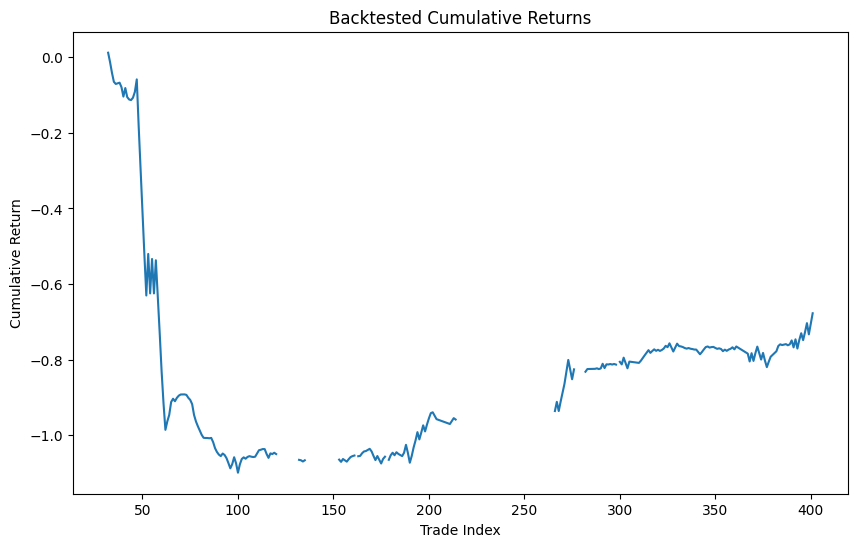

              Timestamp Signal  Predicted_Avg_Short_MI  Return
0   2025-06-20 02:52:00    Buy              309.247772     NaN
1   2025-06-20 06:23:00    Buy              372.833649     NaN
2   2025-06-20 07:28:00   Sell               -7.897753     NaN
3   2025-06-20 07:41:00    Buy              377.681183     NaN
4   2025-06-20 10:43:00    Buy                6.293015     NaN
..                  ...    ...                     ...     ...
412 2025-07-11 18:29:00    Buy                0.298528     NaN
413 2025-07-11 19:25:00    Buy              357.725800     NaN
414 2025-07-11 20:15:00    Buy               30.799372     NaN
415 2025-07-11 21:15:00    Buy              174.641037     NaN
416 2025-07-11 21:40:00    Buy               94.934578     NaN

[384 rows x 4 columns]


In [33]:
# Step 5: Evaluation on Test Data
model.eval()
test_preds_scaled = []
with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)
        outputs = model(features)
        test_preds_scaled.append(outputs.cpu().numpy())

test_preds_scaled = np.vstack(test_preds_scaled)
test_preds = target_scaler.inverse_transform(test_preds_scaled)  # Inverse scale to original MI values

# Compute MSE on test
test_mse = mean_squared_error(test_targets, test_preds)
print(f'Test MSE: {test_mse:.4f}')

# Generate Signals: Threshold MI predictions (e.g., if avg short-term MI > 0.5% positive, buy; < -0.5%, sell)
short_term_mi_cols = [col for col in mi_columns if '1min' in col or '5min' in col]  # Focus on short-term for signals
test_df['Predicted_Avg_Short_MI'] = np.mean(test_preds[:, [mi_columns.index(col) for col in short_term_mi_cols]], axis=1)
test_df['Signal'] = np.where(test_df['Predicted_Avg_Short_MI'] > 0.005, 'Buy',  # 0.5% threshold
                             np.where(test_df['Predicted_Avg_Short_MI'] < -0.005, 'Sell', 'Hold'))

# Filter for low-entropy (high-conviction) only
test_df = test_df[test_df['Entropy'] < entropy_threshold]

# Step 6: Backtesting with OHLCV
# Simulate trades: Buy/Sell at Mid_Open, hold for 15min (example), compute returns
test_df['Mid_Open'] = (test_df['Bid_Open'] + test_df['Ask_Open']) / 2
test_df['Mid_Close_15min'] = test_df['Mid_Open'].shift(-15)  # Approximate 15min close (adjust window)

trades = test_df[test_df['Signal'] != 'Hold']
trades['Return'] = np.where(trades['Signal'] == 'Buy',
                            (trades['Mid_Close_15min'] - trades['Mid_Open']) / trades['Mid_Open'],
                            (trades['Mid_Open'] - trades['Mid_Close_15min']) / trades['Mid_Open'])

# Metrics
win_rate = (trades['Return'] > 0).mean()
cum_returns = trades['Return'].cumsum()
sharpe_ratio = trades['Return'].mean() / trades['Return'].std() * np.sqrt(252)  # Annualized

print(f'Win Rate: {win_rate:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}')
print('Cumulative Returns:')
print(cum_returns.tail())

# Visualization: Cumulative Returns Plot
plt.figure(figsize=(10, 6))
plt.plot(cum_returns)
plt.title('Backtested Cumulative Returns')
plt.xlabel('Trade Index')
plt.ylabel('Cumulative Return')
plt.show()

# Table for Comparisons (e.g., signal vs. actual MI)
comparison_table = trades[['Timestamp', 'Signal', 'Predicted_Avg_Short_MI', 'Return']]
print(comparison_table)